## Analysis of Nb.BsrDI-induced DNA breaks

<div style="text-align: right">
    21.12.2023
    <br>
    Vakil Takhaveev, PhD
</div>

In this notebook, we generate the following figures of the paper:
* Supplementary Fig. 4a-b.

In [1]:
#importing necessary modules
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import argparse
import Bio
from Bio.Seq import Seq
from Bio import SeqIO
import seaborn as sns
import scipy
import logomaker as lm
import sys
print(sys.version)

3.8.5 (default, Oct  6 2020, 10:04:29) 
[GCC 6.3.0]


In [2]:
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("matplotlib", mpl.__version__)
print("Bio", Bio.__version__)
print("seaborn", sns.__version__)
print("scipy", scipy.__version__)
#print("logomaker", lm.__version__) logomaker 0.8

numpy 1.19.2
pandas 1.1.3
matplotlib 3.4.2
Bio 1.76
seaborn 0.11.1
scipy 1.6.3


In [3]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['mathtext.default'] = "regular"

mpl.rcParams['font.size'] = 16

In [4]:
chromosome_list = ['chr' + str(i) for i in np.arange(1, 23, 1)] + ['chrX']
chromosome_list

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr20',
 'chr21',
 'chr22',
 'chrX']

### The nickase patterns in the genome reference

##### First option of counting the number of nickase sites

In [5]:
def count_patterns_in_the_reference(input_fasta, chromosome_list, PATTERN):
    count = 0
    for record in SeqIO.parse(input_fasta, "fasta"):
        chr_name = record.name.split(":")[0]
        if chr_name in chromosome_list:
            print(record.name, end = " ")
            count += record.seq.upper().count_overlap(PATTERN)
            count += record.seq.upper().reverse_complement().count_overlap(PATTERN)

    return count

In [6]:
#the whole genome
#bowtie2-inspect GRCh38_noalt_as/GRCh38_noalt_as > GRCh38_noalt_as.fasta

input_fasta = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/genomes/GRCh38_NCBI_Bowtie2_index/GRCh38_noalt_as.fasta"
count_patterns_in_the_reference(input_fasta, chromosome_list, "CATTGC")

chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX 

1418639

##### Second option of counting the number of nickase sites

In [5]:
import re

def find_overlapping_indexes(string, substring):
    pattern = "(?={})".format(re.escape(substring))
    indexes = [match.start() for match in re.finditer(pattern, string)]
    return indexes

In [6]:
string = "abababa"
substring = "aba"
indexes = find_overlapping_indexes(string, substring)
print(indexes)

[0, 2, 4]


In [7]:
def count_patterns_in_the_reference2(input_fasta, chromosome_list, PATTERN):
    count = 0
    for record in SeqIO.parse(input_fasta, "fasta"):
        chr_name = record.name.split(":")[0]
        if chr_name in chromosome_list:
            print(record.name, end = " ")
            count += len(find_overlapping_indexes(str(record.seq.upper()), PATTERN))
            count += len(find_overlapping_indexes(str(record.seq.upper().reverse_complement()), PATTERN))

    return count

In [8]:
#the whole genome
#bowtie2-inspect GRCh38_noalt_as/GRCh38_noalt_as > GRCh38_noalt_as.fasta

input_fasta = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/genomes/GRCh38_NCBI_Bowtie2_index/GRCh38_noalt_as.fasta"
count_patterns_in_the_reference2(input_fasta, chromosome_list, "CATTGC")

chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX 

1418639

##### Determining the coordinates of the nickase sites using the Second option (above)

In [7]:
def get_coordinates_of_pattern_in_the_reference2(input_fasta, chromosome_list, PATTERN):
    
    df = pd.DataFrame({})
    
    for record in SeqIO.parse(input_fasta, "fasta"):
        chr_name = record.name.split(":")[0]
        if chr_name in chromosome_list:
            chr_seq_forward = str(record.seq.upper())
            chr_seq_rev = str(record.seq.upper().reverse_complement())
            
            chr_length = len(chr_seq_forward)
            print(record.name, chr_length)
            
            coors_forward = find_overlapping_indexes(chr_seq_forward, PATTERN)
            coors_rev = find_overlapping_indexes(chr_seq_rev, PATTERN)
            coors_rev = (chr_length - 1) - np.array(coors_rev)
            
            tmp_forward = pd.DataFrame({"Coordinate" : coors_forward})
            tmp_forward.loc[:, "Strand"] = "+"
            tmp_rev = pd.DataFrame({"Coordinate" : coors_rev})
            tmp_rev.loc[:, "Strand"] = "-"
            tmp = pd.concat([tmp_forward, tmp_rev])
            tmp.loc[:, "Chromosome"] = record.name
            df = pd.concat([df, tmp])

    df = df.reset_index(drop = True)
    return df

In [8]:
#the whole genome
#bowtie2-inspect GRCh38_noalt_as/GRCh38_noalt_as > GRCh38_noalt_as.fasta

input_fasta = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/genomes/GRCh38_NCBI_Bowtie2_index/GRCh38_noalt_as.fasta"
DF_pattern_coords = get_coordinates_of_pattern_in_the_reference2(input_fasta, chromosome_list, "CATTGC")
DF_pattern_coords

chr1 248956422
chr2 242193529
chr3 198295559
chr4 190214555
chr5 181538259
chr6 170805979
chr7 159345973
chr8 145138636
chr9 138394717
chr10 133797422
chr11 135086622
chr12 133275309
chr13 114364328
chr14 107043718
chr15 101991189
chr16 90338345
chr17 83257441
chr18 80373285
chr19 58617616
chr20 64444167
chr21 46709983
chr22 50818468
chrX 156040895


Coordinate Strand Chromosome
0             11365      +       chr1
1             13356      +       chr1
2             15499      +       chr1
3             36016      +       chr1
4             45990      +       chr1
...             ...    ...        ...
1418634      258738      -       chrX
1418635      258367      -       chrX
1418636      238508      -       chrX
1418637      223890      -       chrX
1418638       11493      -       chrX

[1418639 rows x 3 columns]

In [9]:
OUTPATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Positive_control/"

#DF_pattern_coords.to_csv(OUTPATH + "CATTGC_coordinates_in_human_genome.csv")

### Identified breaks in the proximity of the nickase sites

In [5]:
OUTPATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Positive_control/"
DF_pattern_coords = pd.read_csv(OUTPATH + "CATTGC_coordinates_in_human_genome.csv")
DF_pattern_coords = DF_pattern_coords.loc[:, ["Chromosome", "Coordinate", "Strand"]]
DF_pattern_coords = DF_pattern_coords.reset_index(drop = True)
DF_pattern_coords.loc[:, "Site"] = DF_pattern_coords.index
DF_pattern_coords

Chromosome  Coordinate Strand     Site
0             chr1       11365      +        0
1             chr1       13356      +        1
2             chr1       15499      +        2
3             chr1       36016      +        3
4             chr1       45990      +        4
...            ...         ...    ...      ...
1418634       chrX      258738      -  1418634
1418635       chrX      258367      -  1418635
1418636       chrX      238508      -  1418636
1418637       chrX      223890      -  1418637
1418638       chrX       11493      -  1418638

[1418639 rows x 4 columns]

In [6]:
!head /nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Sample_folders/20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gz/bed_and_bedgraph/UMIdedup_UMIremoved_trimmed_20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gzGRCh38.p13.DAMAGE.bed

chr1	10086	10087	A01251:407:HV2MKDRXY:1:2128:2239:26976_TTCTTACTGT	6	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2141:24849:25050_CTTGAAAGCA	0	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2152:4996:16752_CAATATTGGT	15	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2154:30083:16830_TCCACTCTAA	0	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2207:22137:16939_GCAAAGACAT	7	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2213:28393:36918_ACGTGAGTTA	2	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2218:13358:16485_AAAAGTATTC	2	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2219:23158:18270_TTATGTATGC	7	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2223:29152:12931_TTGTAATCAC	6	-
chr1	10086	10087	A01251:407:HV2MKDRXY:1:2225:29414:7216_TAGGAATTAG	6	-


In [7]:
PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Sample_folders/20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gz/bed_and_bedgraph/UMIdedup_UMIremoved_trimmed_20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gzGRCh38.p13.DAMAGE.bed"

df = pd.read_csv(PATH, sep = '\t', header = None)
df = df.rename(columns = {0 : "Chromosome", 1 : "Coordinate", 5 : "Strand"})
df = df.loc[:, ["Chromosome", "Coordinate", "Strand"]]
df.loc[:, "Strand"] = df['Strand'].apply(lambda x: '-' if x == '+' else '+')
df = df[df["Chromosome"].isin(chromosome_list)]
print("All breaks", df.shape[0])
df = df.drop_duplicates()
df = df.reset_index(drop = True)
print("Deduplicated breaks", df.shape[0])
df

All breaks 29078285
Deduplicated breaks 4677167


Chromosome  Coordinate Strand
0             chr1       10086      +
1             chr1       10090      +
2             chr1       10087      +
3             chr1        9986      -
4             chr1       10088      +
...            ...         ...    ...
4677162       chrX   156030743      +
4677163       chrX   156030642      -
4677164       chrX   156030644      -
4677165       chrX   156030645      -
4677166       chrX   156030763      +

[4677167 rows x 3 columns]

In [8]:
####
# Determining the nickase-induced breaks with decreasing resolution (assuming nickase sloppiness)
####

DATA = pd.DataFrame({})

tmp = pd.merge(df, DF_pattern_coords, on = ["Chromosome", "Coordinate", "Strand"], how = "inner")
tmp.loc[:, "Window"] = 0
DATA = pd.concat([DATA, tmp])
print("Done, WINDOW: 0")

for WINDOW in [1, 2, 3, 4, 5]:
    currDATA = DATA.loc[:, ["Chromosome", "Coordinate", "Strand", "Site"]].copy().drop_duplicates().reset_index(drop = True)
    df_all = pd.merge(df.copy(), currDATA.loc[:, ["Chromosome", "Coordinate", "Strand"]], on=["Chromosome", "Coordinate", "Strand"], 
                      how='left', indicator=True)
    df_to_use = df_all[df_all["_merge"] == 'left_only']
    df_to_use = df_to_use.loc[:, ["Chromosome", "Coordinate", "Strand"]].drop_duplicates().reset_index(drop = True)
    
    for chrom in chromosome_list:
        for strand in ["+", "-"]:
            df_ref = DF_pattern_coords[(DF_pattern_coords["Chromosome"] == chrom) & (DF_pattern_coords["Strand"] == strand)].copy()
            df_ref.loc[:, "Upstr_boundary"] = df_ref["Coordinate"] - WINDOW
            df_ref.loc[:, "Downstr_boundary"] = df_ref["Coordinate"] + WINDOW
            df_ref = df_ref.loc[:, ["Upstr_boundary", "Downstr_boundary", "Site"]].reset_index(drop = True)

            df2_ch = df_to_use[(df_to_use["Chromosome"] == chrom) & (df_to_use["Strand"] == strand)].copy().reset_index(drop = True)
            
            a = np.array(df2_ch["Coordinate"].values)
            
            for small_reff in np.array_split(df_ref, 10):
                small_ref = small_reff.reset_index(drop = True)
                bl = np.array(small_ref["Upstr_boundary"].values)
                bh = np.array(small_ref["Downstr_boundary"].values)

                matrix = (a[:, None] >= bl) & (a[:, None] <= bh)
                i,j = np.where(matrix)
                
                tmp = pd.concat([
                            df2_ch.loc[i, :].reset_index(drop=True),
                            small_ref.loc[j, :].reset_index(drop=True)
                        ], axis=1)
                
                if not tmp.empty:
                    tmp.loc[:, "Window"] = WINDOW
                    tmp = tmp.loc[:, ["Chromosome", "Coordinate", "Strand", "Site", "Window"]]
                    DATA = pd.concat([DATA, tmp])

        print(chrom, end = " ")
        
    currDATA.loc[:, "Window"] = WINDOW
    DATA = pd.concat([DATA, currDATA])
    
    print("Done, WINDOW:", WINDOW)


DATA = DATA.drop_duplicates()
DATA = DATA.reset_index(drop = True)
DATA

Done, WINDOW: 0
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX Done, WINDOW: 1
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX Done, WINDOW: 2
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX Done, WINDOW: 3
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX Done, WINDOW: 4
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX Done, WINDOW: 5


Chromosome  Coordinate Strand     Site  Window
0             chr1       11365      +        0     0.0
1             chr1       11611      -   111626     0.0
2             chr1       13356      +        1     0.0
3             chr1       15499      +        2     0.0
4             chr1       16971      -   111623     0.0
...            ...         ...    ...      ...     ...
8493297       chrX     1762419      -  1418248     5.0
8493298       chrX     3223439      -  1417938     5.0
8493299       chrX     3565937      -  1417840     5.0
8493300       chrX     7130833      -  1416858     5.0
8493301       chrX    12391311      -  1415470     5.0

[8493302 rows x 5 columns]

In [9]:
OUTPATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Positive_control/"

#DATA.to_csv(OUTPATH + "Deduplicated_breaks_WINDOWs.csv")

In [7]:
a = np.array([1, 3, 5, 7, 9, 11])
bl = np.array([2, 4, 8])
bh = np.array([6, 8, 10])

(a[:, None] >= bl) 


array([[False, False, False],
       [ True, False, False],
       [ True,  True, False],
       [ True,  True, False],
       [ True,  True,  True],
       [ True,  True,  True]])

In [8]:
(a[:, None] <= bh) 


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [False,  True,  True],
       [False, False,  True],
       [False, False, False]])

In [9]:
ccc = (a[:, None] >= bl) & (a[:, None] <= bh) 
ccc

array([[False, False, False],
       [ True, False, False],
       [ True,  True, False],
       [False,  True, False],
       [False, False,  True],
       [False, False, False]])

In [10]:
np.where(ccc)

(array([1, 2, 2, 3, 4]), array([0, 0, 1, 1, 2]))

### Sensitivity pie chart

In [5]:
PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Positive_control/"

DATAdetected_sites = pd.read_csv(PATH + "Deduplicated_breaks_WINDOWs.csv")
DATAdetected_sites

Unnamed: 0 Chromosome  Coordinate Strand     Site  Window
0                 0       chr1       11365      +        0     0.0
1                 1       chr1       11611      -   111626     0.0
2                 2       chr1       13356      +        1     0.0
3                 3       chr1       15499      +        2     0.0
4                 4       chr1       16971      -   111623     0.0
...             ...        ...         ...    ...      ...     ...
8493297     8493297       chrX     1762419      -  1418248     5.0
8493298     8493298       chrX     3223439      -  1417938     5.0
8493299     8493299       chrX     3565937      -  1417840     5.0
8493300     8493300       chrX     7130833      -  1416858     5.0
8493301     8493301       chrX    12391311      -  1415470     5.0

[8493302 rows x 6 columns]

In [6]:
#stringent way
N_identified_patterns = len(DATAdetected_sites[DATAdetected_sites["Window"] == 0]["Site"].unique())
print(N_identified_patterns)
#Sensitivity of the method
N_identified_patterns/1418639

1238758


0.8732017095258202

In [7]:
#considering nickase sloppiness
N_identified_patterns = len(DATAdetected_sites["Site"].unique())
print(N_identified_patterns)
#Sensitivity of the method
N_identified_patterns/1418639

1243395


0.876470335300242

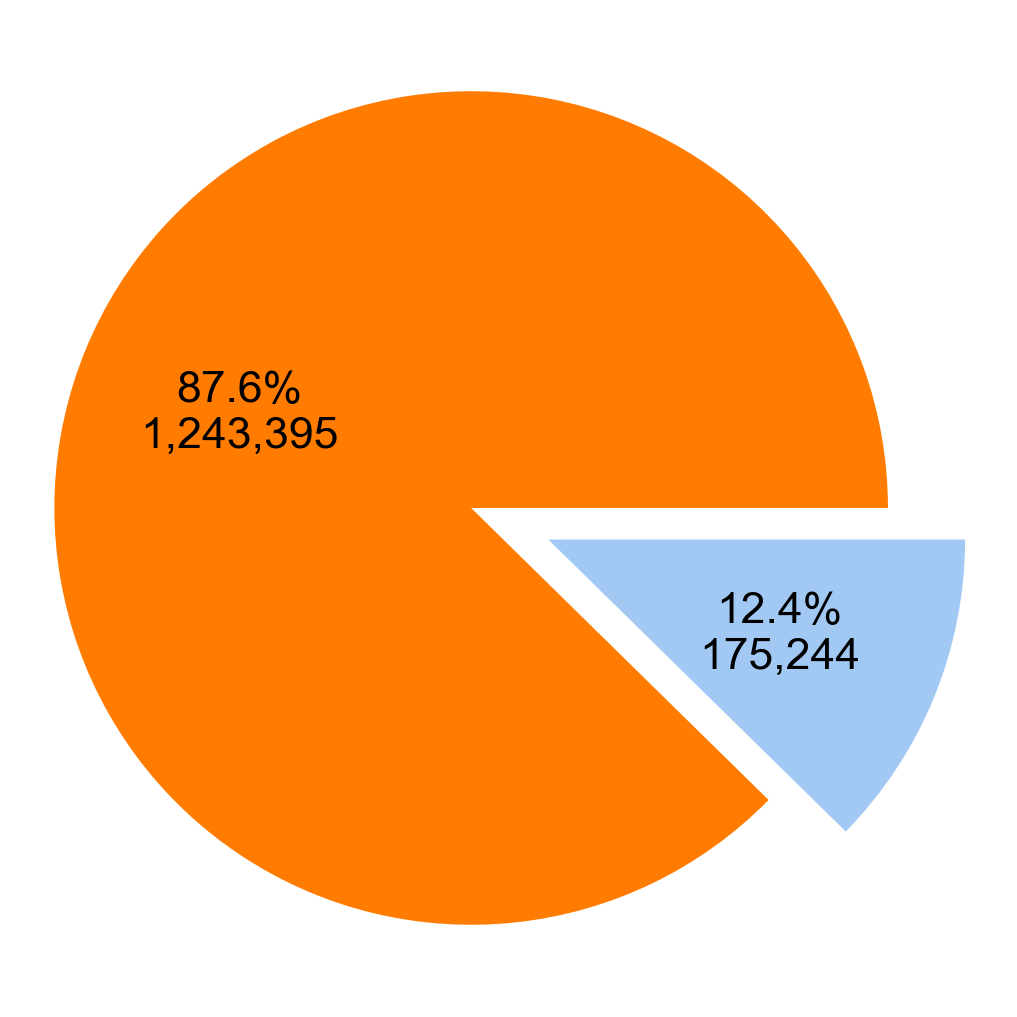

In [8]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = '', ''

sizes = [N_identified_patterns, 1418639 - N_identified_patterns]
explode = (0.2, 0)
colors = [sns.color_palette("bright")[1], sns.color_palette("pastel")[0]]

fig = plt.figure(1, (5, 5), dpi = 200)
ax = plt.subplot(1, 1, 1)

def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    #return "{:.1f}%\n{:d}".format(pct, absolute)
    return "{:.1f}%\n".format(pct) + f"{absolute:,}"

ax.pie(sizes, explode=explode, labels=labels, autopct=lambda pct: func(pct, sizes),#'%1.1f%%',
        shadow=False, startangle=0, colors = colors)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.tight_layout(pad = 0.25)
plt.savefig("../DamageSeqAnalysis/GLOEseq/GLOEseq_MayJulyOct2022_Jan2023/MS_FIGURES/Sensitivity_piechart.pdf")

### Precision

In [9]:
PATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/Sample_folders/20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gz/bed_and_bedgraph/UMIdedup_UMIremoved_trimmed_20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gzGRCh38.p13.DAMAGE.bed"

df = pd.read_csv(PATH, sep = '\t', header = None)
df = df.rename(columns = {0 : "Chromosome", 1 : "Coordinate", 5 : "Strand"})
df = df.loc[:, ["Chromosome", "Coordinate", "Strand"]]
df.loc[:, "Strand"] = df['Strand'].apply(lambda x: '-' if x == '+' else '+')
df = df[df["Chromosome"].isin(chromosome_list)]
df = df.reset_index(drop = True)

sum_total = df.shape[0]
print("All breaks", sum_total)

df

All breaks 29078285


Chromosome  Coordinate Strand
0              chr1       10086      +
1              chr1       10086      +
2              chr1       10086      +
3              chr1       10086      +
4              chr1       10086      +
...             ...         ...    ...
29078280       chrX   156030738      +
29078281       chrX   156030644      -
29078282       chrX   156030644      -
29078283       chrX   156030645      -
29078284       chrX   156030763      +

[29078285 rows x 3 columns]

[82.46078130123561, 83.54371999586633, 83.92225332408702, 84.00642954011903, 84.08549541350186, 84.24699737278179] 29078285


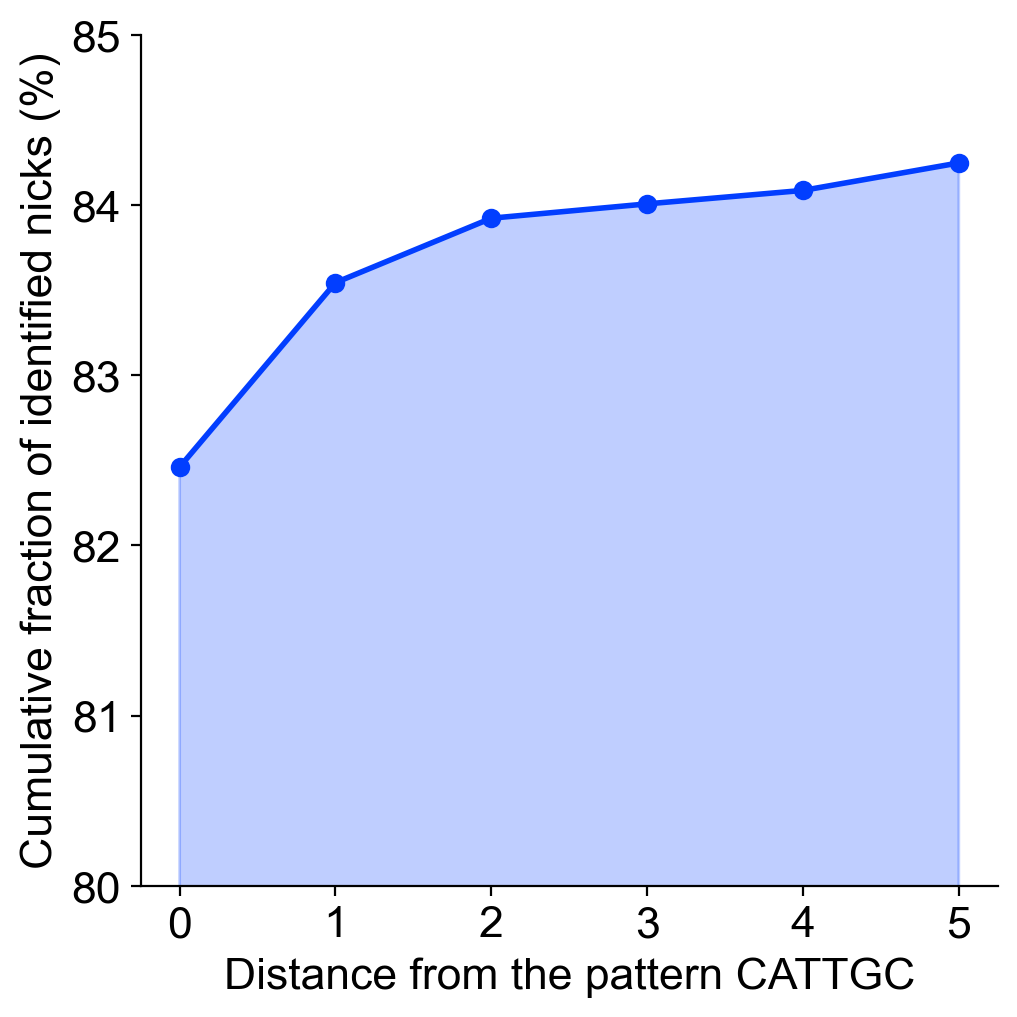

In [10]:
fig = plt.figure(1, (5, 5), dpi = 200)
ax = plt.subplot(1, 1, 1)

#'''
distance_list = []
fraction_list = []

for i in range(6):
    tmp = DATAdetected_sites[DATAdetected_sites["Window"] == i].copy()
    tmp = tmp.loc[:, ["Chromosome", "Coordinate", "Strand"]].drop_duplicates().reset_index(drop = True)
    
    tmp = pd.merge(tmp, df, on = ["Chromosome", "Coordinate", "Strand"])
    sum_i = tmp.shape[0]
    
    frac = 100*sum_i/sum_total
    distance_list += [i]
    fraction_list += [frac]
#'''    
print(fraction_list, sum_total)
    
ax.plot(distance_list, fraction_list, 'o-', color = sns.color_palette("bright")[0], alpha = 1, lw = 2)
ax.fill_between(distance_list, fraction_list, color = sns.color_palette("bright")[0], alpha = 0.25)


ax.set_xlabel("Distance from the pattern CATTGC")
ax.set_ylabel("Cumulative fraction of identified nicks (%)")

ax.set_ylim(80, 85)
#ax.set_yticks([0, 20, 40, 60, 80, 90, 100])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout(pad = 0.25)
plt.savefig("../DamageSeqAnalysis/GLOEseq/GLOEseq_MayJulyOct2022_Jan2023/MS_FIGURES/Cumulative_number_of_identified_nicks.pdf")
#plt.close(fig)


In [11]:
#OUTPATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/SOURCE_DATA/csv_files/"

handle1 = pd.DataFrame({"Distance from the pattern CATTGC" : distance_list, 
                       "Cumulative fraction of identified nicks (%)" : fraction_list})
#handle.to_csv(OUTPATH + "Source_data_FigS4a.csv", index = False)
handle1

Distance from the pattern CATTGC  \
0                                 0   
1                                 1   
2                                 2   
3                                 3   
4                                 4   
5                                 5   

   Cumulative fraction of identified nicks (%)  
0                                    82.460781  
1                                    83.543720  
2                                    83.922253  
3                                    84.006430  
4                                    84.085495  
5                                    84.246997

## Editing the logo

In [14]:
TMP = pd.read_csv("../DamageSeqAnalysis/GLOEseq/GLOEseq_May2022_analysis/Positive_control/LOGOfromBED_UMIdedup_UMIremoved_trimmed_20220525.B-o28326_1_13-13-Emma-Vakil_R1.fastq.gz_FALSE_ALL_uniqueFALSE_freq.csv")
TMP['IC'] = [2]*len(TMP)

for ntt in ['A', 'C', 'G', 'T']:
    TMP.loc[:, ntt + "_log"] = np.log2(TMP[ntt])
    TMP.loc[:, 'IC'] += TMP[ntt]*TMP[ntt + "_log"]

TMP.loc[:, 'A'] = TMP['A']*TMP['IC']
TMP.loc[:, 'T'] = TMP['T']*TMP['IC']
TMP.loc[:, 'G'] = TMP['G']*TMP['IC']
TMP.loc[:, 'C'] = TMP['C']*TMP['IC']


TMP

pos         A         C         G         N         T        IC     A_log  \
0     0  0.004248  0.003483  0.004584  0.000027  0.005413  0.017729 -2.061212   
1     1  0.009032  0.006758  0.005140  0.000027  0.007376  0.028307 -1.648003   
2     2  0.028695  0.022630  0.014362  0.000029  0.043578  0.109268 -1.929013   
3     3  0.001365  0.001452  0.001423  0.000029  0.001721  0.005961 -2.126996   
4     4  0.005627  0.004009  0.004734  0.000030  0.006303  0.020674 -1.877274   
5     5  0.013764  0.021245  0.010621  0.000031  0.023542  0.069174 -2.329320   
6     6  0.008246  0.018118  0.016509  0.000032  0.018941  0.061815 -2.906230   
7     7  0.023361  0.040560  0.014488  0.000032  0.021744  0.100157 -2.100104   
8     8  0.071809  1.224440  0.029944  0.000037  0.039708  1.365952 -4.249594   
9     9  1.274168  0.042829  0.043709  0.000039  0.044425  1.405185 -0.141205   
10   10  0.059474  0.045777  0.030209  0.000040  1.253996  1.389511 -4.546182   
11   11  0.047609  0.042986  0.030519  0.000041  1.335945  1.457120 -4.935743   
12   12  0.041938  0.055372  1.086234  0.000043  0.062602  1.246201 -4.893120   
13   13  0.043672  1.185652  0.045493  0.000045  0.056010  1.330887 -4.929546   
14   14  0.080505  0.048780  0.012611  0.000050  0.075737  0.217644 -1.434811   
15   15  0.008374  0.009040  0.006402  0.000054  0.011988  0.035805 -2.096184   
16   16  0.012291  0.010057  0.009471  0.000055  0.017992  0.049813 -2.018895   

       C_log     G_log     T_log  
0  -2.347832 -1.951315 -1.711525  
1  -2.066514 -2.461435 -1.940148  
2  -2.271589 -2.927511 -1.326192  
3  -2.037813 -2.066609 -1.791938  
4  -2.366487 -2.126805 -1.713635  
5  -1.703094 -2.703313 -1.555017  
6  -1.770528 -1.904744 -1.706470  
7  -1.304116 -2.789294 -2.203568  
8  -0.157785 -5.511479 -5.104333  
9  -5.036028 -5.006681 -4.983247  
10 -4.923816 -5.523452 -0.148045  
11 -5.083093 -5.577252 -0.125258  
12 -4.492227 -0.198201 -4.315195  
13 -0.166708 -4.870603 -4.570557  
14 -2.157603 -4.109237 -1.522905  
15 -1.985836 -2.483572 -1.578617  
16 -2.308338 -2.394993 -1.469204

In [15]:
info_mat2 = TMP.loc[:, ['A', 'C', 'G', 'T']]
PROXIMITY = 8

fig = plt.figure(1, (1*5, 1*5), dpi = 200)
        
        
ax = plt.subplot(1, 1, 1)
# create and style logo
logo = lm.Logo(df=info_mat2, ax = ax, color_scheme= 'classic', stack_order='big_on_top', font_name='Arial')

# set axes labels
ax.set_xlabel('Position')
ax.set_ylabel("Information (bit)")
    
value = 29078285 
ax.text(0.95, 0.95, str(f'{value:,}') + ' nicks',
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes)

ax.set_ylim(-0.05, 2.05)
ax.set_yticks([0, 0.5, 1, 1.5, 2])
            
ax.set_xticks(np.arange(0, 2*PROXIMITY + 1, 1))
ax.set_xticklabels(np.arange(-PROXIMITY, PROXIMITY + 1, 1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(pad = 0.25)
plt.savefig('../DamageSeqAnalysis/GLOEseq/GLOEseq_MayJulyOct2022_Jan2023/MS_FIGURES/Positive_control_LOGO.pdf')
plt.close(fig)


In [17]:
info_mat2.loc[:, "Position"] = np.arange(-PROXIMITY, PROXIMITY + 1, 1)
info_mat2

A         C         G         T  Position
0   0.004248  0.003483  0.004584  0.005413        -8
1   0.009032  0.006758  0.005140  0.007376        -7
2   0.028695  0.022630  0.014362  0.043578        -6
3   0.001365  0.001452  0.001423  0.001721        -5
4   0.005627  0.004009  0.004734  0.006303        -4
5   0.013764  0.021245  0.010621  0.023542        -3
6   0.008246  0.018118  0.016509  0.018941        -2
7   0.023361  0.040560  0.014488  0.021744        -1
8   0.071809  1.224440  0.029944  0.039708         0
9   1.274168  0.042829  0.043709  0.044425         1
10  0.059474  0.045777  0.030209  1.253996         2
11  0.047609  0.042986  0.030519  1.335945         3
12  0.041938  0.055372  1.086234  0.062602         4
13  0.043672  1.185652  0.045493  0.056010         5
14  0.080505  0.048780  0.012611  0.075737         6
15  0.008374  0.009040  0.006402  0.011988         7
16  0.012291  0.010057  0.009471  0.017992         8

In [18]:
handle = pd.concat([info_mat2, handle1], axis = 1)

OUTPATH = "/nfs/nas12.ethz.ch/fs1201/green_groups_let_public/Euler/Vakil/GLOEseq_all_ET743_AF_data_processed/SOURCE_DATA/csv_files/"

handle.to_csv(OUTPATH + "Source_data_FigS4a.csv", index = False)
handle

A         C         G         T  Position  \
0   0.004248  0.003483  0.004584  0.005413        -8   
1   0.009032  0.006758  0.005140  0.007376        -7   
2   0.028695  0.022630  0.014362  0.043578        -6   
3   0.001365  0.001452  0.001423  0.001721        -5   
4   0.005627  0.004009  0.004734  0.006303        -4   
5   0.013764  0.021245  0.010621  0.023542        -3   
6   0.008246  0.018118  0.016509  0.018941        -2   
7   0.023361  0.040560  0.014488  0.021744        -1   
8   0.071809  1.224440  0.029944  0.039708         0   
9   1.274168  0.042829  0.043709  0.044425         1   
10  0.059474  0.045777  0.030209  1.253996         2   
11  0.047609  0.042986  0.030519  1.335945         3   
12  0.041938  0.055372  1.086234  0.062602         4   
13  0.043672  1.185652  0.045493  0.056010         5   
14  0.080505  0.048780  0.012611  0.075737         6   
15  0.008374  0.009040  0.006402  0.011988         7   
16  0.012291  0.010057  0.009471  0.017992         8   

    Distance from the pattern CATTGC  \
0                                0.0   
1                                1.0   
2                                2.0   
3                                3.0   
4                                4.0   
5                                5.0   
6                                NaN   
7                                NaN   
8                                NaN   
9                                NaN   
10                               NaN   
11                               NaN   
12                               NaN   
13                               NaN   
14                               NaN   
15                               NaN   
16                               NaN   

    Cumulative fraction of identified nicks (%)  
0                                     82.460781  
1                                     83.543720  
2                                     83.922253  
3                                     84.006430  
4                                     84.085495  
5                                     84.246997  
6                                           NaN  
7                                           NaN  
8                                           NaN  
9                                           NaN  
10                                          NaN  
11                                          NaN  
12                                          NaN  
13                                          NaN  
14                                          NaN  
15                                          NaN  
16                                          NaN